# Student Performance Project - Iwas Iwas

<img src="Data/exam.jpg" />

In this project I am going to analyze:

1. Do students with parents that have a college degree perform better?
2. Does having a free/reduced meal have an impact on the performance?
3. The Gender race: Who scores better in which subject? Who scores better in total?
4. Does having a good score in one subject contribute to having a good score in another subject?
5. Do race differences show different performances?
6. Do people that complete the test preparation course score higher?

Bonus: In the end, I will build an SVM-classifier to predict if a student performed above or below average based on parental background, test preparation, etc.

*The [Dataset](http://roycekimmons.com/tools/generated_data/exams) used in this project includes scores from three exams and a variety of personal, social, and economic factors that have interaction effects upon them.*

**Let's start by importing libraries and performing a brief exploratory data analysis and initial preprocessing before we break down the questions above.**

In [22]:
#Import libaries, Load Dataset, Show head of Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.3)

df = pd.read_csv("StudentsPerformance.csv")
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


As you can see, we don't have to deal with missing values or wrong dtypes in this dataset, which normally is the case in real-life data.

       math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000


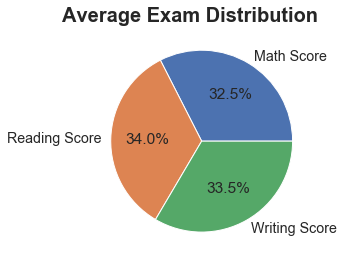

In [24]:
labels = ['Math Score', 'Reading Score', 'Writing Score']
values = [df['math score'].mean(), df['reading score'].mean(), df['writing score'].mean()]

_ = plt.pie(values, labels=labels, autopct='%1.1f%%') #autopct displays the percentages
_ = plt.title('Average Exam Distribution', y=1, x=0.45, fontsize = 20, weight='bold')
plt.tight_layout()

print(df.describe())

There are some interesting findings here. The average student scores highest on the reading exam, followed by writing and the lowest scores are in the maths exam. The math exam is also the only one where we have students with 0 points. Nevertheless, some students scored full points in each exam.

Let's sum up all the scores and create a new feature with the total score for each student.

In [25]:
df['total score'] = df['math score'] + df['reading score'] + df['writing score']

### 1. Do students with parents that have a college degree perform better? ###

In [26]:
df['parental level of education'].unique()

array(["bachelor's degree", 'some college', "master's degree",
       "associate's degree", 'high school', 'some high school'],
      dtype=object)

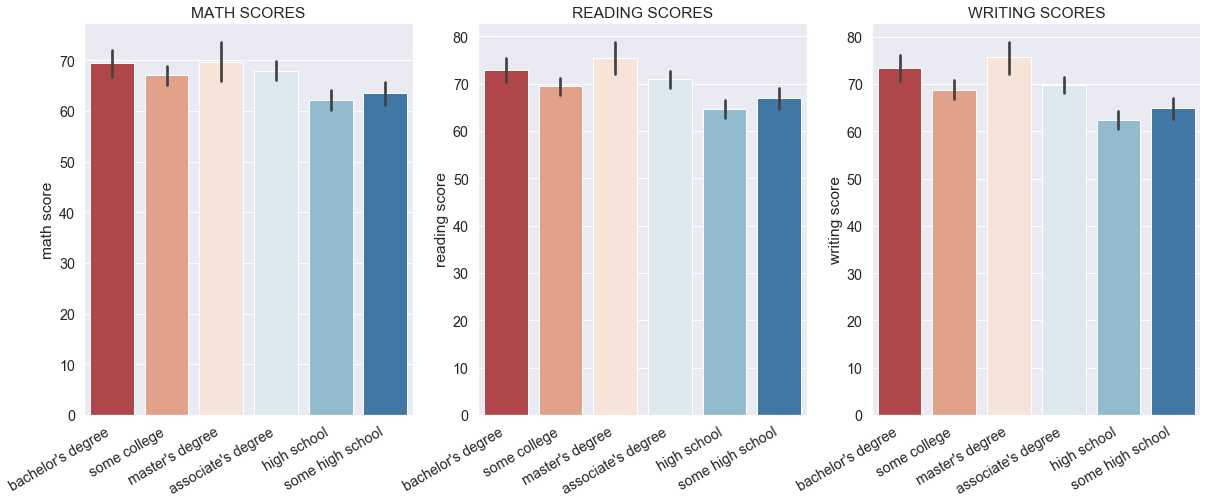

In [28]:
fig = plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
sns.barplot(x='parental level of education',y='math score',data=df,palette='RdBu')
fig.autofmt_xdate()
plt.xlabel('')
plt.title('MATH SCORES')
plt.subplot(1, 3, 2)
sns.barplot(x='parental level of education',y='reading score',data=df,palette='RdBu')
fig.autofmt_xdate()
plt.xlabel('')
plt.title('READING SCORES')
plt.subplot(1, 3, 3)
sns.barplot(x='parental level of education',y='writing score',data=df, palette='RdBu')
fig.autofmt_xdate()
plt.xlabel('')
plt.title('WRITING SCORES')
plt.show()

As you can see, the higher the degree (master's > bachelor's > associates/some college > high school/some high school) the higher the score in each exam. To get a clearer Picture I will summarize the degrees into a degree if the parents went to college and no degree if they only went to high school. 

Let's filter the top performer (250-300 total points) and low Performer (0-150 total points) and look at their parental level of education.

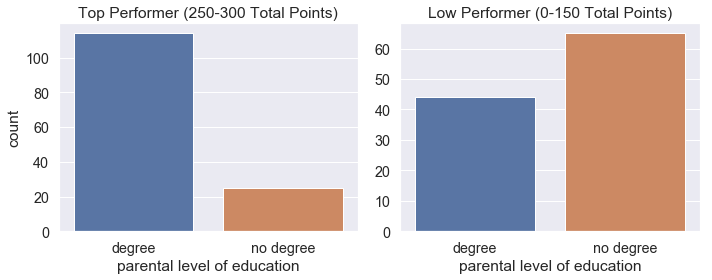

In [7]:
df['parental level of education'] = np.where((df['parental level of education'] == "bachelor's degree") | 
                      (df['parental level of education'] == 'some college') | 
                      (df['parental level of education'] == "master's degree") | 
                      (df['parental level of education'] == "associate's degree"), 'degree', 'no degree')

top_scorer = df[df['total score']>=250]
low_scorer = df[df['total score']<=150]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))  # 1 row, 2 columns
_ = sns.countplot(top_scorer['parental level of education'], ax=ax1)
_2 = sns.countplot(low_scorer['parental level of education'], ax=ax2)
_2 = plt.ylabel('')
ax1.set_title('Top Performer (250-300 Total Points)')
ax2.set_title('Low Performer (0-150 Total Points)')
plt.tight_layout()  

As one would expect the parents of the top performer are much more likely to have a degree and on the flip side, they tend to have no degree among the low performer.

### 2. Does having a free/reduced meal have an impact on the performance?

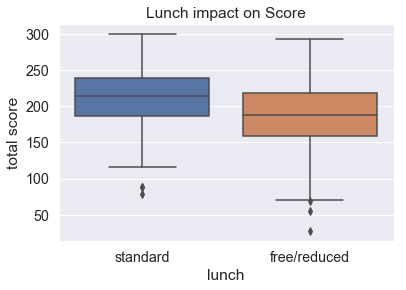

In [8]:
_ = sns.boxplot(x='lunch', y='total score', data=df)
_ = _.set_title('Lunch impact on Score')

It appears that having free/reduced lunch has no positive impact on scoring higher in the exams. One can even say that students that had standard lunch before the exams performed better in general (25th, 50th, and 75th percentile is higher). This could be traced down to being in their normal study routine. This is similar to the assumption that if you chew the same gum you chewed while studying in the exam, you will perform better. 

### 3. The Gender Race: Who scores better in which subject? Who scores best in total?

According to this [paper](https://web.stanford.edu/~niederle/NV.JEP.pdf) published by Stanford, males perform better in Maths due to the difference in their response to competition. Can we confirm this with our Data? What about reading and writing? Let's find out!

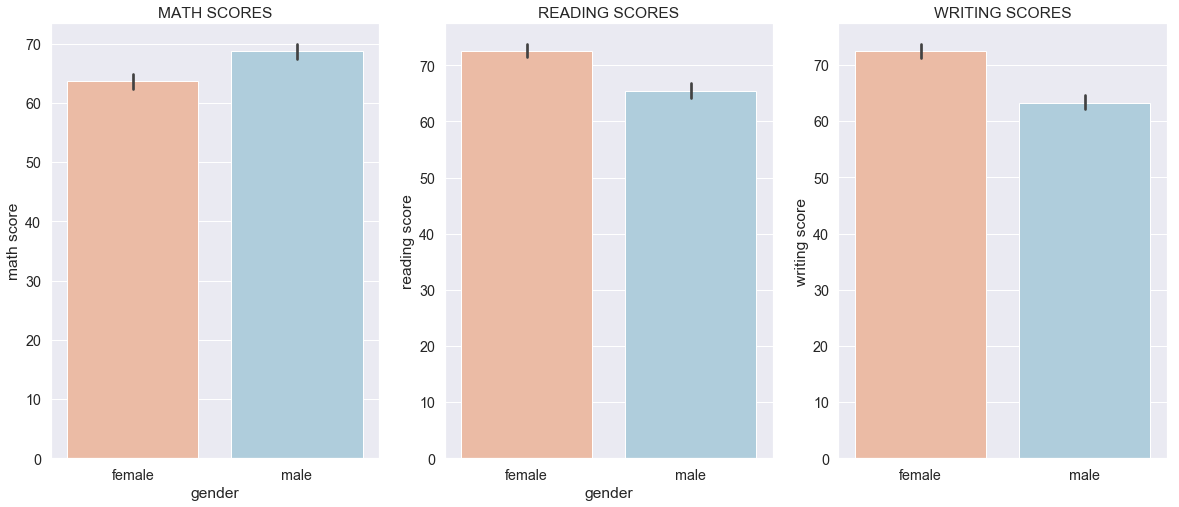

In [9]:
fig = plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
sns.barplot(x='gender',y='math score',data=df,palette='RdBu')
plt.title('MATH SCORES')
plt.subplot(1, 3, 2)
sns.barplot(x='gender',y='reading score',data=df,palette='RdBu')
plt.title('READING SCORES')
plt.subplot(1, 3, 3)
sns.barplot(x='gender',y='writing score',data=df, palette='RdBu')
plt.xlabel('')
plt.title('WRITING SCORES')
plt.show()

As expected, males performed better in the math exam, while females had the upper hand in reading and writing.

What about the total score?

In [10]:
male_meanscore = df[df['gender']=='male']['total score'].mean()
female_meanscore = df[df['gender']=='female']['total score'].mean()
print('Male mean total score: {}'.format(round(male_meanscore)))
print('Female mean total score: {}'.format(round(female_meanscore)))

Male mean total score: 198
Female mean total score: 209


Males might perform better in maths, but because females score better in reading and writing and not too bad in maths, they outscore the males on average by 11 Points!

### 4. Does having a good score in one subject contribute to having a better score in another subject?

Let's plot a correlation matrix with the different scores.

In [11]:
corr = df[['math score','reading score','writing score']].corr()
corr.style.background_gradient(cmap='coolwarm')

,math score,reading score,writing score
math score,1,0.81758,0.802642
reading score,0.81758,1,0.954598
writing score,0.802642,0.954598,1


As you can see, there are strong positive correlations between each score. This suggests that if you score high in one subject you will probably also score high on the other subjects! We can visualize this by plotting a pair-plot and make sure to confirm that this is the case for both male and females by setting the hue to gender.

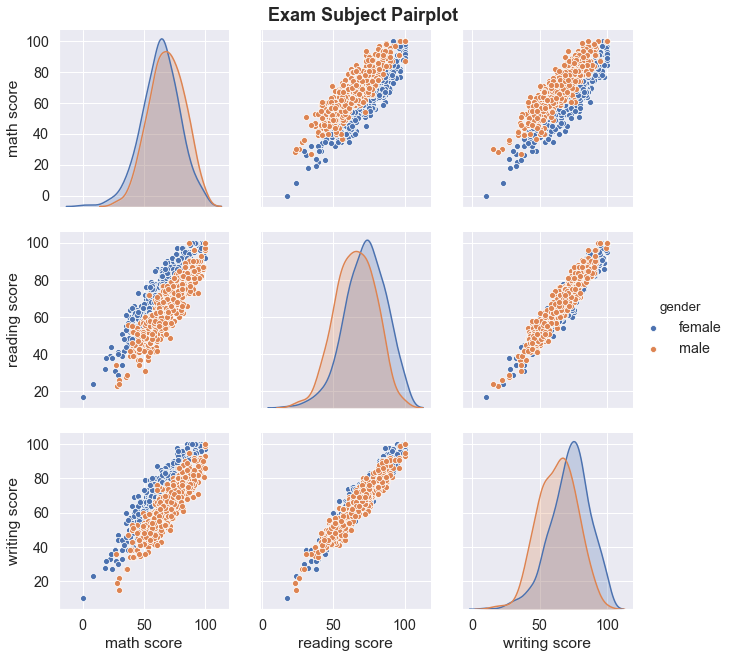

In [12]:
g = sns.pairplot(df, height=3, vars=[('math score'), ('reading score'), ('writing score')], hue='gender')
g = g.fig.suptitle("Exam Subject Pairplot", y=1.01, weight='bold', fontsize = 18)

Interpretation:

- The higher the math score, the reading and writing score
- the higher the reading score, the higher the math and writing score
- The higher the writing score, the higher the math and reading score

### 5. Do race differences show different performences?

In [13]:
df['race/ethnicity'].value_counts()

group C    319
group D    262
group B    190
group E    140
group A     89
Name: race/ethnicity, dtype: int64

We have five different race categories that attended the exams. Sadly, we don't know which race stands for which group but it's safe to assume that each is a unique race (e.g. German, Asian).

Let's find out how each race performed in each subject!

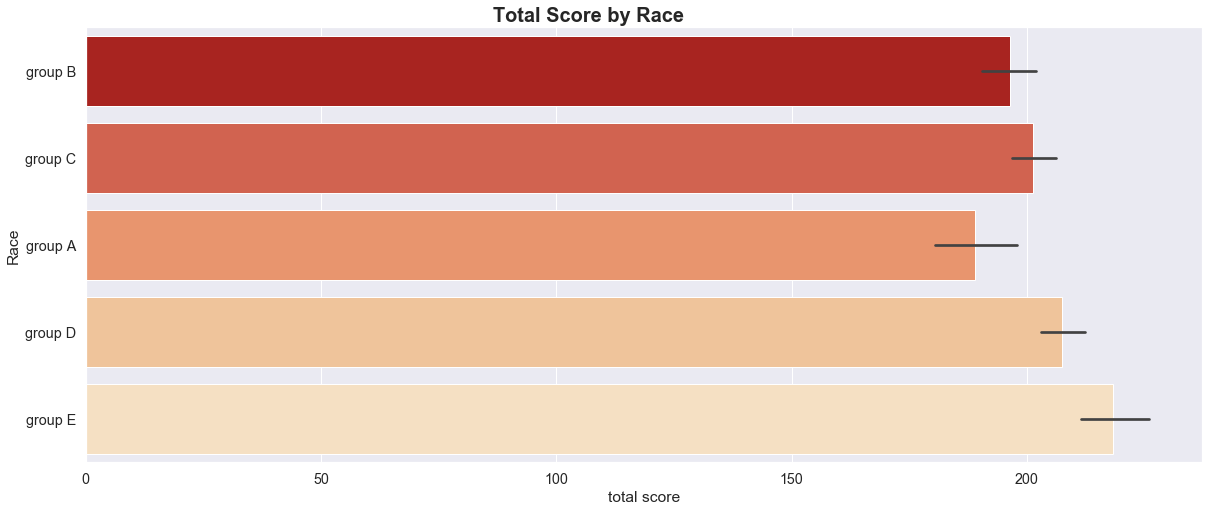

In [14]:
fig = plt.figure(figsize=(20,8))
_ = sns.barplot(x='total score', y='race/ethnicity', data=df, palette = 'OrRd_r')
_ = plt.title('Total Score by Race', y=1, x=0.45, fontsize = 20, weight='bold')
_ = plt.ylabel('Race')

There are some differences in the performance in each race. For instance, group A students have the lowest scores and group E students the highest.

To close this subject, let's look at the mean total scores for each. The results should look like to the barplot above.

In [15]:
print(df.groupby('race/ethnicity')['total score'].mean())

race/ethnicity
group A    188.977528
group B    196.405263
group C    201.394984
group D    207.538168
group E    218.257143
Name: total score, dtype: float64


The assumption is correct! Another interesting thing to note is that the higher the group, (A<B<C<D<E) the higher the average total score.

In [16]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score
0,female,group B,degree,standard,none,72,72,74,218
1,female,group C,degree,standard,completed,69,90,88,247
2,female,group B,degree,standard,none,90,95,93,278
3,male,group A,degree,free/reduced,none,47,57,44,148
4,male,group C,degree,standard,none,76,78,75,229


### 6. Do people that completed the test preparation course score higher?

First of all, let's check out the group distribution as a function of participating in the test preparation course.

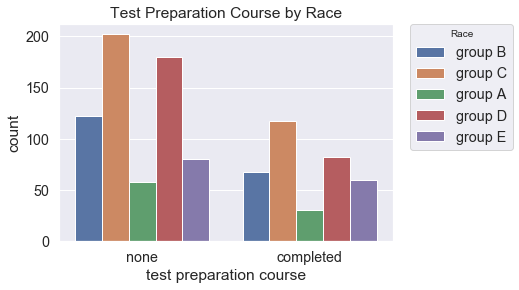

In [17]:
_ = sns.countplot('test preparation course', data=df, hue ='race/ethnicity')
_ = _.set_title('Test Preparation Course by Race')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
_ = _.set_title('Race')

Interesting insights/Assumptions:

- As we saw in Chapter 5, out of all groups group A had the lowest average score. Logically, they have the lowest attendance frequency.


- The race group C stands for seem to be the *hard worker*. They have the highest preparation score attendance frequency but as chapter 5 highlights, they only managed to achieve average scores.


- Looks like group E students are the smartest. They have the second-lowest preparation course attendance frequency. Nevertheless scored the highest in the exams.

**But did the test preparation course really lead to higher scores?**

You can't say that for sure. It is highly likely that students that attend those courses tend to study more than students who don't use these *extra opportunities*. To close this chapter, let's look at the mean performance differences in each subject distinguished by the test preparation course status.

In [18]:
print(df.groupby('test preparation course')['math score'].mean())
print('-------')
print(df.groupby('test preparation course')['reading score'].mean())
print('-------')
print(df.groupby('test preparation course')['writing score'].mean())

test preparation course
completed    69.695531
none         64.077882
Name: math score, dtype: float64
-------
test preparation course
completed    73.893855
none         66.534268
Name: reading score, dtype: float64
-------
test preparation course
completed    74.418994
none         64.504673
Name: writing score, dtype: float64


The average score on each exam is higher on every subject for students that attended the preparation course.

### 6. Bonus: Predict performance 

Let's start by defining the above-average and below-average score space and create a new column!

In [19]:
average = df['total score'].mean()
print('average score: {}'.format(average))
#No one scored exacly the mean, so we can leave the 'equal' operation out.
df['performance'] = np.where(df['total score']>average, 'above average', 'below average')
df[['total score', 'performance']].head()

average score: 203.312


,total score,performance
0,218,above average
1,247,above average
2,278,above average
3,148,below average
4,229,above average


In the next step, let's encode the categorical features by creating dummies to be able to fit them to our model for the prediction. Let's also enable the drop_first parameter to drop redundant features that would bias the model. 

In [20]:
df_encoded = pd.get_dummies(df, columns=['gender',
                                         'race/ethnicity', 
                                         'parental level of education', 
                                         'lunch', 'test preparation course'], drop_first=True)

Finally, I will train-test-split the features I want to predict the performance with, instantiate a Support Vector Machine and pass it to a GridSearch to find good hyperparameters.

In [21]:
X = df_encoded.drop(['math score', 'reading score', 'writing score', 'total score', 'performance'], axis=1).values #add values to transform df to np array
y = df['performance'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25)

#Instantiate RBF SVM
svm = SVC(kernel='rbf')

#Instantiate GridSearchCV
parameters = {'C':[0.1, 1, 10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher = GridSearchCV(svm, parameters, cv=5)
searcher.fit(X_train, y_train)

#Best parameters and the corresponding score
print("Best CV params", searcher.best_params_)
print("Best CV accuracy", searcher.best_score_)

#Test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", searcher.score(X_test, y_test))

Best CV params {'C': 1, 'gamma': 0.1}
Best CV accuracy 0.6533333333333333
Test accuracy of best grid search hypers: 0.64


We managed to achieve a test accuracy score of 64%. As this isn't the main goal of this project I won't go into depth with model evaluation/optimization.

### Conclusion: breaking down the initial questions

**Parental level of education**

When it comes to the parental background, students performed better if their parents have college degrees. The higher the degree, the higher the score. I also visualized that among the top performer most of the parents attended college and on the contrary, among the low performer most of the parents only attended high school (Chapter 1).

If you want to read more about this topic, check out this [Paper](https://pdfs.semanticscholar.org/9c0c/4014dc24fcec4555a9bf017726f86ddc231d.pdf) from the Universal Journal of Educational Research.

During this project, I managed to analyze that parental background (having a college degree) leads to better performance in exams. 

**Free/reduced or standard meal?**

It appears that having free/reduced lunch has no positive impact on scoring higher in the exams. One can even say that students that had standard lunch before the exams performed better in general (25th, 50th, and 75th percentile is higher). I assume that this is due to the students being in their normal study routine. 

This could be traced down to being in their normal study routine. This is similar to the assumption that if you chew the same gum you chewed while studying in the exam, you will perform better ([Research Report](http://www.stlawu.edu/sites/default/files/resource/Onyper%2C%20Carr%2C%20Farrar%2C%20and%20Floyd%20%282011%29.pdf)).

**The Gender race: Who scores better in which subject? Who scores better in total?**

Males performed better in maths, but since females score better in reading and writing and not too bad in maths, they outscore the males on average by 11 Points!

**Does having a good score in one subject contribute to having a good score in another subject?**

I created a correlation matrix and a pairplot between each of the subjects. All the subjects have a strong positive correlation between each other, which suggests that if you score high in one subject, you will also not be too bad in the other subjects! (see chapter 4)

**Do race differences show different performances?**

We have five different race categories that attended the exams. Sadly, we don't know which race stands for which group but it's safe to assume that each is a unique race (e.g. German, Asian). There are some differences in the performance in each race. For instance, group A students have the lowest scores and group E students the highest.

**Do people that complete the test preparation course score higher?**

On average, students that attended the test preparation course scored better than the ones that did not. But this is likely not only a result of the course. It is highly likely that students that attend those courses tend to study more than students who don't use these extra opportunities.